# **Wheat Seeds Dataset**
## **Data Pre-Processing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('seeds_dataset.txt', sep="\t", error_bad_lines=False, warn_bad_lines=True)
df.columns=['area','perimeter','compactness','length_kernel','width_kernel', \
            'asymmetry_coeff','length_of_kernel_groove','target']

b'Skipping line 8: expected 8 fields, saw 10\nSkipping line 36: expected 8 fields, saw 10\nSkipping line 61: expected 8 fields, saw 9\nSkipping line 69: expected 8 fields, saw 9\nSkipping line 107: expected 8 fields, saw 9\nSkipping line 136: expected 8 fields, saw 9\nSkipping line 170: expected 8 fields, saw 9\nSkipping line 171: expected 8 fields, saw 9\nSkipping line 173: expected 8 fields, saw 9\nSkipping line 202: expected 8 fields, saw 9\nSkipping line 204: expected 8 fields, saw 9\n'


### Checking data for preprocessing
##### Note:
 - Normalization is not important for DTs, RFs, and GBTs since the splitting rules are not dependent on the scaling of the data. 
 - Feature selection is also not important for DTs, RFs, and GBTs because during the induction of decision trees, the optimal feature is selected to split the data based on metrics like information gain.
 - Removing/replacing missing values would be considered.
 - Removing outliers would be considered.

In [ ]:
df.head()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_of_kernel_groove,target
0,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
1,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
2,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
3,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
4,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1


In [ ]:
df.describe()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_of_kernel_groove,target
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,14.917020,14.594596,0.870810,5.642545,3.265298,3.706683,5.421667,2.000000
std,2.927276,1.313651,0.023379,0.444635,0.379266,1.471047,0.493759,0.812341
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.315000,13.470000,0.856900,5.267000,2.953750,2.600250,5.046000,1.000000
50%,14.405000,14.360000,0.873450,5.541000,3.243500,3.634500,5.229500,2.000000
75%,17.502500,15.827500,0.886900,6.004000,3.565250,4.812000,5.879000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.315000,6.550000,3.000000


In [ ]:
df.shape

(198, 8)

In [ ]:
df.isnull().sum()

area                       0
perimeter                  0
compactness                0
length_kernel              0
width_kernel               0
asymmetry_coeff            0
length_of_kernel_groove    0
target                     0
dtype: int64

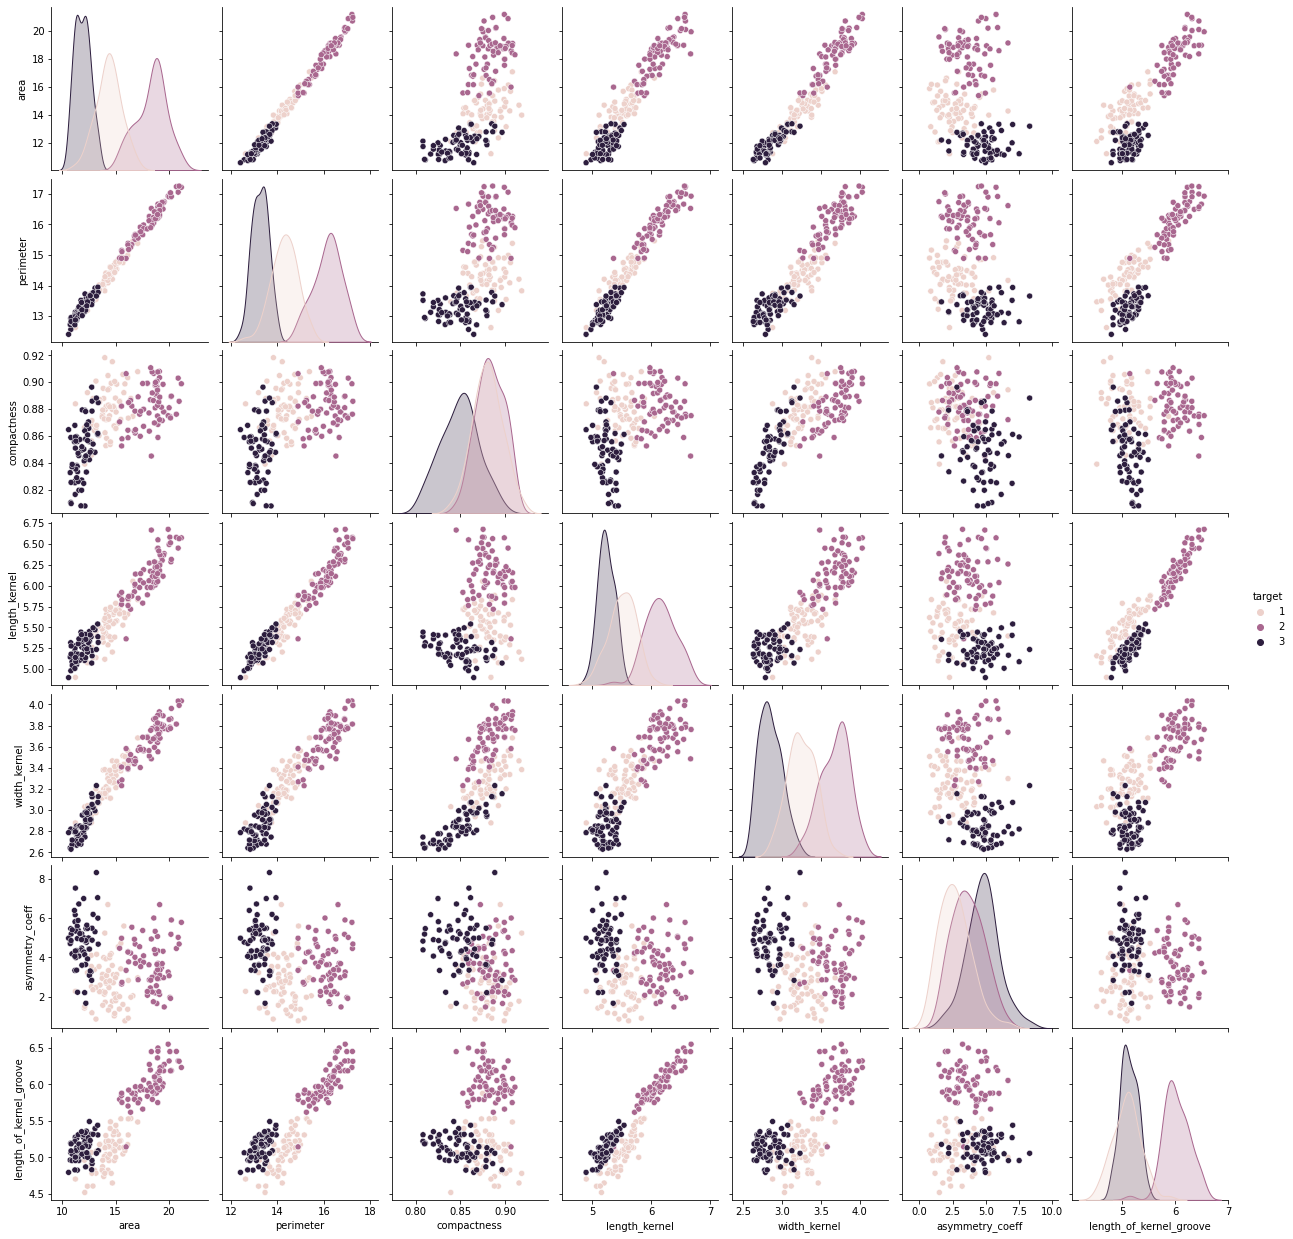

In [ ]:
sns.pairplot(df, hue='target')
plt.show()

### Checking for Outliers

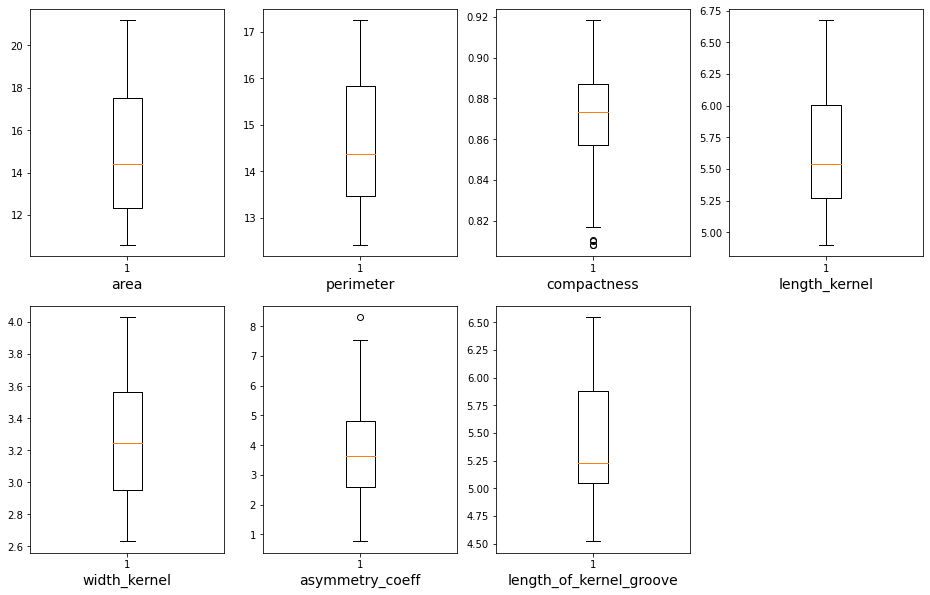

In [ ]:
width = 4
height = 5
plt.figure(figsize=(width*4,height*2))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(2,4,i)
    plt.boxplot(df[column])
    plt.xlabel(column, fontsize=14)

### Removing Outliers Using IQR

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_clean = df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]

print ("Shape before cleaning: ",df.shape)
print ("Shape after IQR: ",df_clean.shape)

Shape before cleaning:  (198, 8)
Shape after IQR:  (193, 8)


# **Tree-based Classifiers and Ensembles**

References:
*   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
*   https://scikit-learn.org/stable/modules/grid_search.html
*   https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import tree

### Splitting Original Data

In [ ]:
X = df[df.columns[:-1]]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 20% test

### Splitting Cleaned Data

In [ ]:
X_clean = df_clean[df_clean.columns[:-1]]
y_clean = df_clean['target']
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=0) # 20% test

## **Decision Tree (DT)**
*   Max depth: {3, 5, 10, None}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
max_depth = [3, 5, 10, None]
parameters = {'max_depth': max_depth, 'random_state': [0]}

### Checking Performance BEFORE Removing Outliers

In [ ]:
dtc = DecisionTreeClassifier()
clf = GridSearchCV(estimator=dtc, param_grid=parameters, cv=10)
clf.fit(X_train, y_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.87916667 0.89875    0.905      0.905     ]


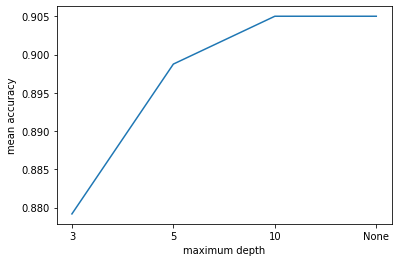

In [ ]:
plt.plot(max_depth[:-1]+['None'], accuracy)
plt.xlabel('maximum depth')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'max_depth': 10}


Evaluate Performance on Test Dataset

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",dt_accuracy)

Accuracy: 0.9


### Checking Performance AFTER Removing Outliers

In [ ]:
dtc = DecisionTreeClassifier()
clf = GridSearchCV(estimator=dtc, param_grid=parameters, cv=10)
clf.fit(X_c_train, y_c_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.90875 0.915   0.915   0.915  ]


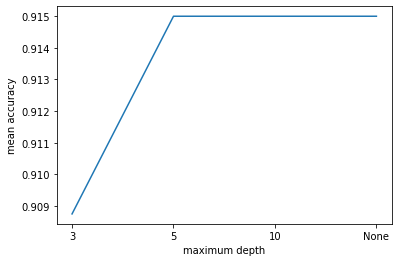

In [ ]:
plt.plot(max_depth[:-1]+['None'], accuracy)
plt.xlabel('maximum depth')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'max_depth': 5}


Evaluate Performance on Test Dataset

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf = clf.fit(X_c_train,y_c_train)
y_pred = clf.predict(X_c_test)
dt_accuracy_c = metrics.accuracy_score(y_c_test, y_pred)
print("Accuracy:",dt_accuracy_c)

Accuracy: 0.8717948717948718


### Use uncleaned data:
*   Accuracy using uncleaned data = 0.9
*   Accuracy using cleaned data = 0.8717948717948718
*   Cleaned data (without outliers) gives worse accuracy compared to uncleaned data, suggesting that the removed outliers may be important. So, outliers removal is not considered for DT.

In [ ]:
algo = []
score = []
algo.append('DT')
score.append(dt_accuracy)

#### Best parameter: max_depth = 10

##### Note:
*   "None" means splitting until leafs are pure, which leads to maximum possible depth.
*   Both 10 and "None" have the same best val_accuracy. This is because the maximum possible depth for our model is 6, as shown in the trees below.
*   The best parameter for maximum depth is chosen to be 10, since generally it is better to pick smaller value for maximum depth and to avoid using maximum possible depth (None) in order to avoid overfitting our model to the training data.
 

Examine the final resulting splitting rules used for the trees

max_depth = 3:


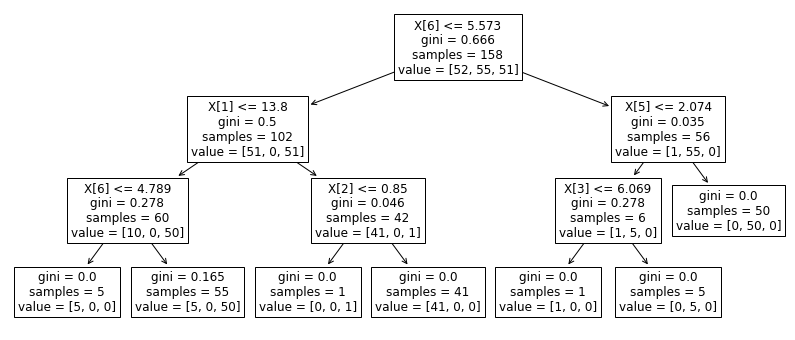

In [ ]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf = clf.fit(X_train,y_train)
plt.figure(figsize=[14,6])
tree.plot_tree(clf, fontsize=12)
print("max_depth = 3:")
plt.show()

max_depth = 5:


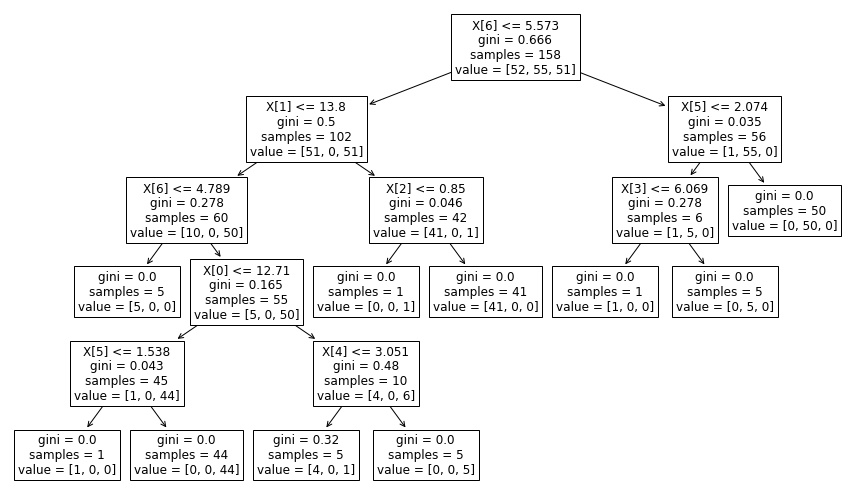

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf = clf.fit(X_train,y_train)
print("max_depth = 5:")
plt.figure(figsize=[15,9])
tree.plot_tree(clf, fontsize=12)
plt.show()

max_depth = 10:


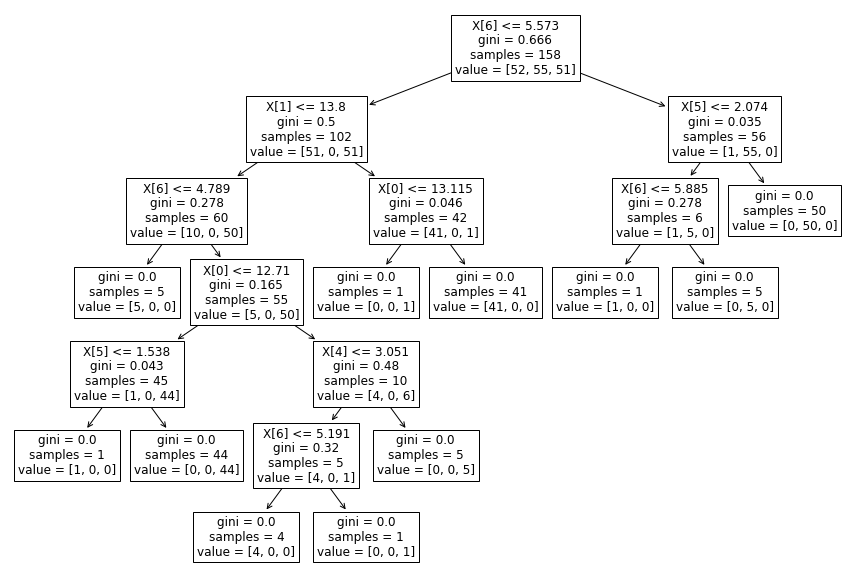

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf = clf.fit(X_train,y_train)
print("max_depth = 10:")
plt.figure(figsize=[15,10.5])
tree.plot_tree(clf, fontsize=12)
plt.show()

max_depth = None:


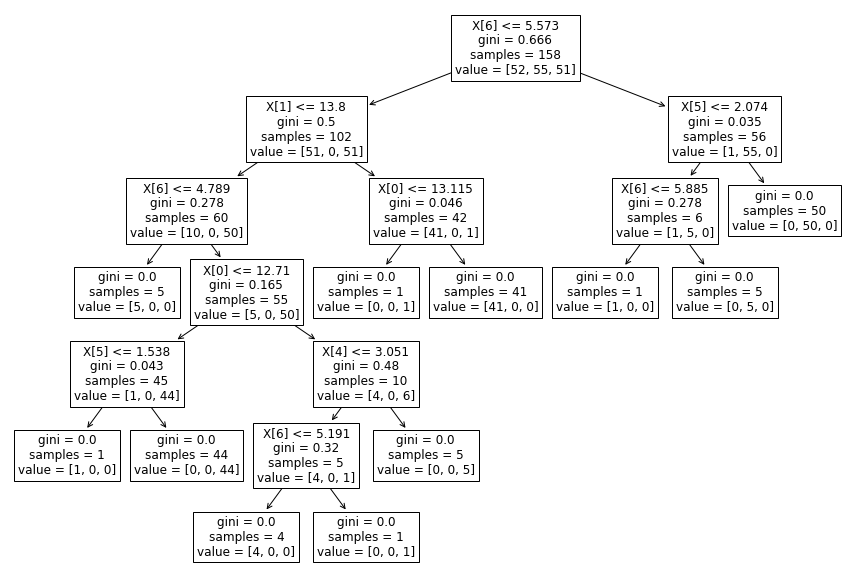

In [ ]:
clf = DecisionTreeClassifier(max_depth=None, random_state=0)
clf = clf.fit(X_train,y_train)
print("max_depth = None:")
plt.figure(figsize=[15,10.5])
tree.plot_tree(clf, fontsize=12)
plt.show()

##### **Splitting Rules**
- Decision trees use multiple algorithms to decide to split a node in two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that purity of the node increases with respect to the target variable. Decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.
- Impurity is a measure of the homogeneity of the labels on a node. There are many ways to implement the impurity measure, two of which scikit-learn has implemented is the Information gain and Gini Impurity / Gini Index.
- Information gain uses the entropy measure as the impurity measure and splits a node such that it gives the most amount of information gain. Whereas Gini Impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity.

##### **Comments for our model and the dataset**
 - In our model we use the the default parameters for the decision tree classifier except the maximum depth, so in this case, splitting depends on the Gini Index.
 - The number of samples (training set) is 158.
 - Based on the splitting rules for max-depth = None, the maximum possible depth is 6. Thus, max-depth = 10 has the same splitting rules as max-depth = None.
 - The root node is splitted at feature x[6] (length_of_kernel_groove) <= 5.573 (i.e. length of kernel groove <= 5.573 on LHS, and length of kernel groove > 5.573 on RHS). For the longer kernel groove (length_of_kernel_groove > 5.573) on RHS, the majority of its samples is in the second target class ('2' = Rosa) at 55/56, indicating that length_of_kernel_groove is a very important feature to determine classifier target 'Rosa'.
 - For the shorter kernel groove (length_of_kernel_groove <= 5.573) at depth = 1 on LHS, half of the samples is in the first target class ('1' = Kama), and the other half is in the third target class ('3' = Canadian). These samples are splitted at feature x[1] (perimeter) <= 13.8 (i.e. shorter perimeter on LHS, and longer perimeter on RHS).
   * For the shorter perimeter on LHS, the majority of its samples is in the third target class (Canadian) at 50/60, indicating that length_of_kernel_groove and perimeter are very important features to determine classifier target 'Canadian'.
   * For the longer perimeter on RHS, the majority of its samples is in the first target class (Kama) at 41/42, indicating that length_of_kernel_groove and perimeter are also very important features to determine classifier target 'Kama'.
 - For the first pure leaf node at depth = 2 on the very right side, the splitting rules included length_of_kernel_groove > 5.573 and asymmetry_coeff > 2.074, meaning that for long kernel groove (> 5.573) and large asymmetry_coeff (> 2.074), target is 'Rosa'.
 - At lower levels (depth = 2 and 4), there are leaf nodes with higher Gini index but small portion of samples from their parent nodes.
 - In overall, based on the performance in reducing gini score on large number of samples, some noticably important features in the splitting rules include Age_Group, Case_AcquisitionInfo, and Outbreak_Related; Reporting_PHU_Longitude and Reporting_PHU_City may be important too.

## **Random Forest (RF)**
*   Number of trees: {5, 10, 50, 150, 200}
*   Max depth: {3, 5, 10, None}



In [ ]:
from sklearn.ensemble import RandomForestClassifier
number_of_trees = [5, 10, 50, 150, 200]
max_depth = [3, 5, 10, None]
parameters = {'n_estimators': number_of_trees, 'max_depth': max_depth, \
              'random_state': [0]}

### Checking Performance BEFORE Removing Outliers

In [ ]:
rfc = RandomForestClassifier()
clf = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
clf.fit(X_train, y_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.89166667 0.89208333 0.91125    0.89208333 0.89833333 0.91125
 0.93       0.91125    0.91083333 0.90458333 0.905      0.92416667
 0.91166667 0.905      0.91125    0.905      0.92416667 0.91166667
 0.905      0.91125   ]


In [ ]:
accuracy_df = pd.DataFrame(data=np.reshape(accuracy, (-1, 5)), \
                           index=max_depth[:-1]+['None'], \
                           columns=number_of_trees)
print(accuracy_df)

           5         10        50        150       200
3     0.891667  0.892083  0.911250  0.892083  0.898333
5     0.911250  0.930000  0.911250  0.910833  0.904583
10    0.905000  0.924167  0.911667  0.905000  0.911250
None  0.905000  0.924167  0.911667  0.905000  0.911250


### Heat plot: (5 * 4) mean accuracies for different values of number of trees and maximum depth


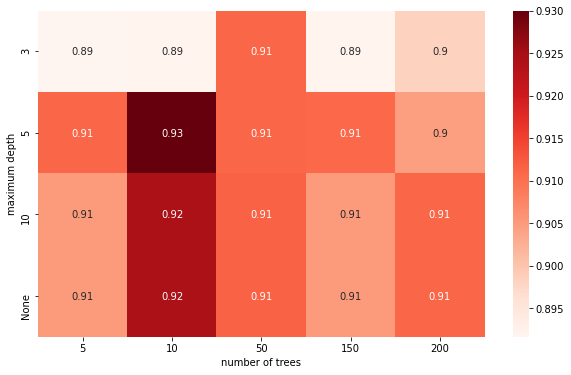

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(accuracy_df, annot=True, cmap=plt.cm.Reds)
plt.xlabel('number of trees') 
plt.ylabel('maximum depth') 
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'max_depth': 5, 'n_estimators': 10}


Evaluate Performance on Test Dataset

In [ ]:
clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",rf_accuracy)

Accuracy: 0.9


### Checking Performance AFTER Removing Outliers

In [ ]:
rfc = RandomForestClassifier()
clf = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
clf.fit(X_c_train, y_c_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.90875    0.90833333 0.895      0.90125    0.90125    0.92833333
 0.9275     0.92125    0.90791667 0.91416667 0.92208333 0.92791667
 0.9275     0.90791667 0.91458333 0.92208333 0.92791667 0.9275
 0.90791667 0.91458333]


In [ ]:
accuracy_df = pd.DataFrame(data=np.reshape(accuracy, (-1, 5)), \
                           index=max_depth[:-1]+['None'], \
                           columns=number_of_trees)
print(accuracy_df)

           5         10       50        150       200
3     0.908750  0.908333  0.89500  0.901250  0.901250
5     0.928333  0.927500  0.92125  0.907917  0.914167
10    0.922083  0.927917  0.92750  0.907917  0.914583
None  0.922083  0.927917  0.92750  0.907917  0.914583


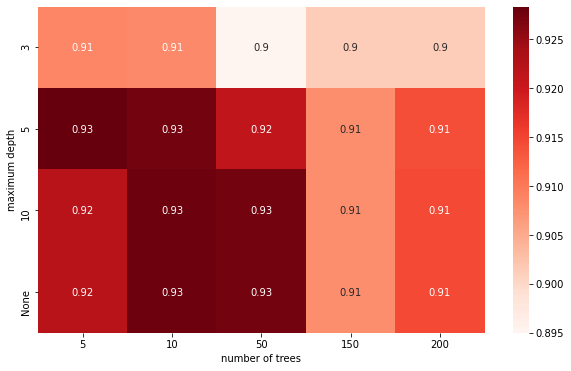

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(accuracy_df, annot=True, cmap=plt.cm.Reds)
plt.xlabel('number of trees') 
plt.ylabel('maximum depth') 
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'max_depth': 5, 'n_estimators': 5}


Evaluate Performance on Test Dataset

In [ ]:
clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=0)
clf = clf.fit(X_c_train,y_c_train)
y_pred = clf.predict(X_c_test)
rf_accuracy_c = metrics.accuracy_score(y_c_test, y_pred)
print("Accuracy:",rf_accuracy_c)

Accuracy: 0.8717948717948718


### Use uncleaned data:
*   Accuracy using uncleaned data = 0.9
*   Accuracy using cleaned data = 0.8717948717948718
*   Cleaned data (without outliers) gives worse accuracy compared to uncleaned data, suggesting that the removed outliers may be important. So, outliers removal is not considered for RF.

#### Best parameters: number_of_trees = 10, max_depth = 5

In [ ]:
algo.append('RF')
score.append(rf_accuracy)

## **Gradient Tree Boosting (GBT)**
*   Number of estimators: {5, 10, 50, 150, 200}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
number_of_estimators = [5, 10, 50, 150, 200]
parameteres = {'n_estimators': number_of_estimators, 'random_state': [0]}

### Checking Performance BEFORE Removing Outliers

In [ ]:
gbc = GradientBoostingClassifier()
clf = GridSearchCV(estimator=gbc, param_grid=parameteres, cv=10)
clf.fit(X_train, y_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.91125    0.905      0.93083333 0.93083333 0.93083333]


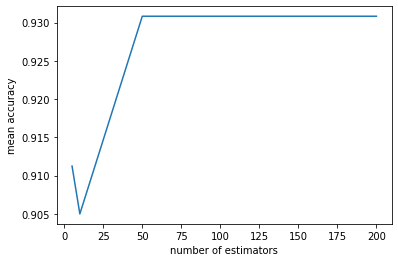

In [ ]:
plt.plot(number_of_estimators, accuracy)
plt.xlabel('number of estimators')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'n_estimators': 50}


Evaluate Performance on Test Dataset

In [ ]:
clf = GradientBoostingClassifier(n_estimators=50, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
gbt_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",gbt_accuracy)

Accuracy: 0.975


### Checking Performance AFTER Removing Outliers

In [ ]:
gbc = GradientBoostingClassifier()
clf = GridSearchCV(estimator=gbc, param_grid=parameteres, cv=10)
clf.fit(X_c_train, y_c_train)
accuracy = clf.cv_results_['mean_test_score']
print(accuracy)

[0.91541667 0.915      0.93458333 0.94083333 0.94083333]


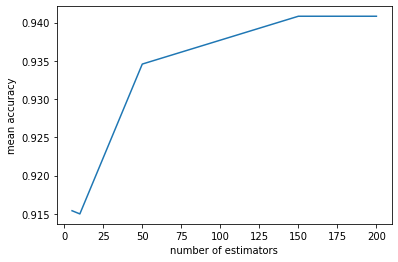

In [ ]:
plt.plot(number_of_estimators, accuracy)
plt.xlabel('number of estimators')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
best_parameters = clf.best_params_
best_parameters.pop('random_state',None)
print("Best parameters:",best_parameters)

Best parameters: {'n_estimators': 150}


Evaluate Performance on Test Dataset

In [ ]:
clf = GradientBoostingClassifier(n_estimators=150, random_state=0)
clf = clf.fit(X_c_train,y_c_train)
y_pred = clf.predict(X_c_test)
gbt_accuracy_c = metrics.accuracy_score(y_c_test, y_pred)
print("Accuracy:",gbt_accuracy_c)

Accuracy: 0.9487179487179487


### Use uncleaned data:
*   Accuracy using uncleaned data = 0.975
*   Accuracy using cleaned data = 0.9487179487179487
*   Cleaned data (without outliers) gives worse accuracy compared to uncleaned data, suggesting that the removed outliers may be important. So, outliers removal is not considered for GBT.

#### Best parameter: number_of_estimators = 50
##### NOTE:
*   The maximum val_accuracy is acheived for the number of estimators 50, 150, and 200.
*   The best parameter for the number of estimator is chosen to be 50 in order to reduce complexity of the model.

In [ ]:
algo.append('GBT')
score.append(gbt_accuracy)

# **Performance Comparison**

### Decision Tree
*   max depth = 10

### Random Forest
*   number of trees = 10
*   max depth = 5

### Gradient Tree Boosting
*   number of estimators = 50

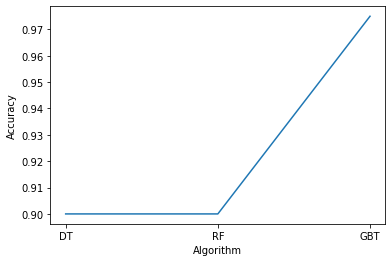

In [ ]:
plt.plot(algo, score)
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.show()

#### **General Comments**
- Random forest will reduce variance part of error rather than bias part, so on a given training data set, decision tree may be more accurate than a random forest. But on an unexpected validation data set, random forest always wins in terms of accuracy.

- Boosting is based on weak learners (high bias, low variance). In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models).

- On the other hand, Random Forest uses fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias.

#### **Comments from our results**
- We expected RF to have a slightly better accuracy than DT, yet the accuracy came out identical. This might be due to the number of training samples being small (only 158).
- GBT yielded better accuracy than other models as a result of its ability to reduce bias.